
# Training a SFNO on the spherical Shallow Water equations

In this example, we demonstrate how to use the small Spherical Shallow Water Equations example we ship with the package
to train a Spherical Fourier-Neural Operator


In [2]:
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np

# Neural Operator Imports
from neuralop.models import SFNO
from neuralop import Trainer
#from neuralop.training import AdamW
from neuralop.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors 


Device: cpu


Loading the Spherical Shallow Water Equations in multiple resolutions



In [3]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


In [4]:
data_train = train_loader.dataset[0]
x_train = data_train['x']
y_train = data_train['y']
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')

x_train.shape: torch.Size([3, 32, 64])
y_train.shape: torch.Size([3, 32, 64])


In [ ]:
data_train = train_loader.dataset[100]
x_train_n = data_train['x']
y_train = data_train['y']
#(x_train-y_train)


In [6]:
# Global constants
g = 9.81  # gravity
N_theta = 64
N_phi = 32
thetaL, thetaR = 0, 2*np.pi # Longitude
phiL, phiR = 0, np.pi # Latitude
t = 0
tend = 0.5 # 1 
CFL = 0.8

d_theta = (thetaR - thetaL) / N_theta
d_phi = (phiR - phiL) / N_phi

# Define the grid
#theta = np.linspace(thetaL + d_theta / 2, thetaR - d_theta / 2, N_theta)
#phi = np.linspace(phiL + d_phi / 2, phiR - d_phi / 2, N_phi)
# Close the circle
theta = np.linspace(0, 2 * np.pi - d_theta, N_theta)  # Starting at 0 for theta
phi = np.linspace(0, np.pi - d_phi, N_phi)           # Starting at 0 for phi

# Center
theta_center = 3*np.pi/2
phi_center = np.pi/3

# Width
sigma = np.pi/16 # Assuming the same width in both directions

# Create the meshgrid
THETA, PHI = np.meshgrid(theta, phi)

In [7]:
r = 1

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)

idx = [0, 10, 20]  # Example: three subplots with different timesteps
#plot_sphere_timesteps(Q_all, X, Y, Z, idx)

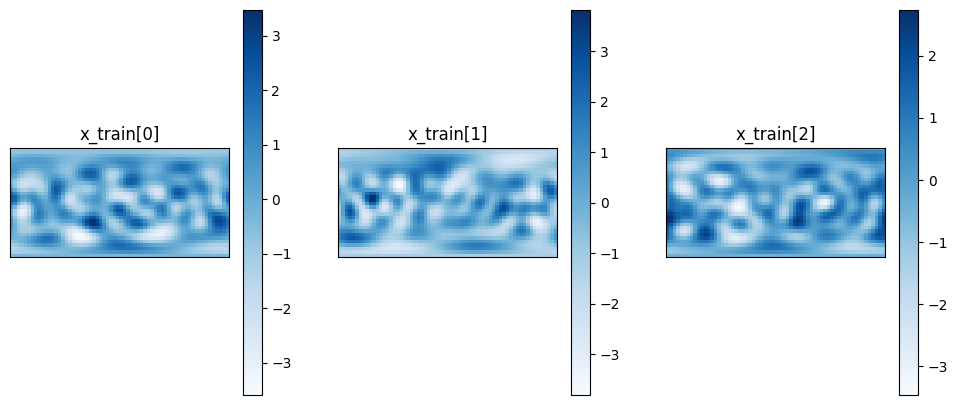

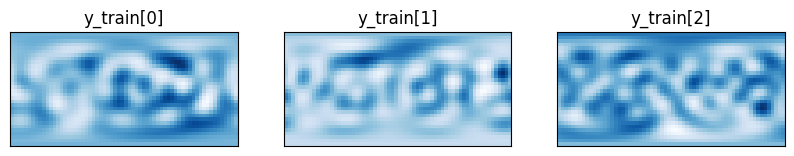

In [8]:
cmap = 'Blues'

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(x_train[0, :, :], cmap=cmap)
plt.colorbar()
plt.title('x_train[0]')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(x_train[1, :, :], cmap=cmap)
plt.title('x_train[1]')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(x_train[2, :, :], cmap=cmap)
plt.title('x_train[2]')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(y_train[0, :, :], cmap=cmap)
plt.title('y_train[0]')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(y_train[1, :, :], cmap=cmap)
plt.title('y_train[1]')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(y_train[2, :, :], cmap=cmap)
plt.title('y_train[2]')
plt.xticks([])
plt.yticks([])

plt.show()

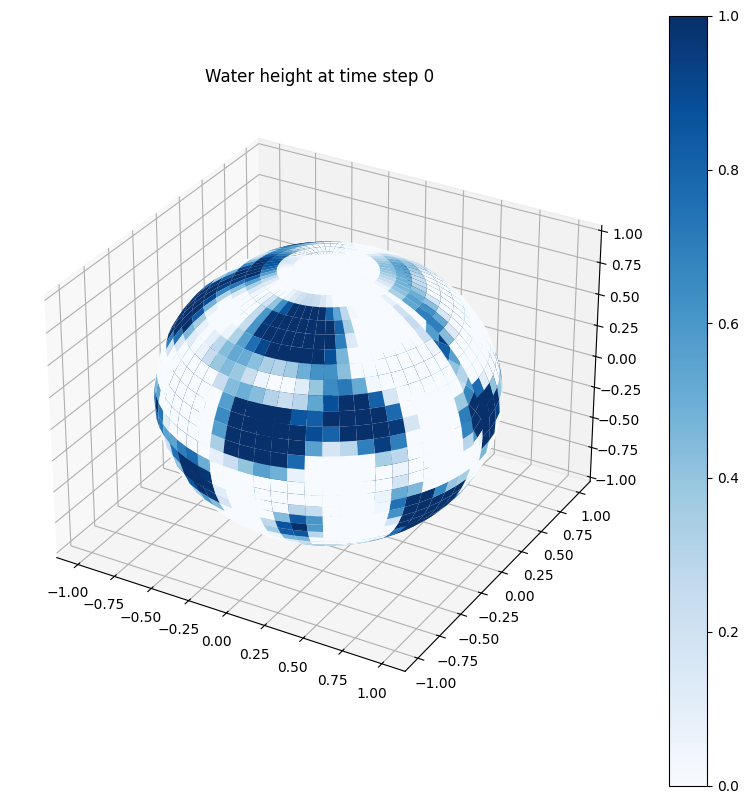

In [12]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = cm.Blues(x_train[0, :, :])  # Map the data to the colormap
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors, cmap=cmap, edgecolor='none')
plt.colorbar(surf)
plt.title("Water height at time step 0")
plt.show()

We create a spherical FNO model



In [6]:
model = SFNO(n_modes=(16, 16),
             in_channels=3,
             out_channels=3,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 153763 parameters.


Create the optimizer



In [7]:
learn_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


Creating the losses



In [8]:
l2loss = LpLoss(d=2, p=2, reduce_dims=(0,1))
# h1loss = H1Loss(d=2, reduce_dims=(0,1))

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [9]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (fno_blocks): FNOBlocks(
    (convs): SphericalConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 16]), rank=None)
      )
      (sht_handle): SHT(
        (_SHT_cache): ModuleDict()
        (_iSHT_cache): ModuleDict()
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    

Create the trainer



In [10]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                 # eval_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


Train the model on the spherical SWE dataset



In [11]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

KeyboardInterrupt: 

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



C:\Users\Matteo\AppData\Local\Temp\ipykernel_19860\2782922215.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


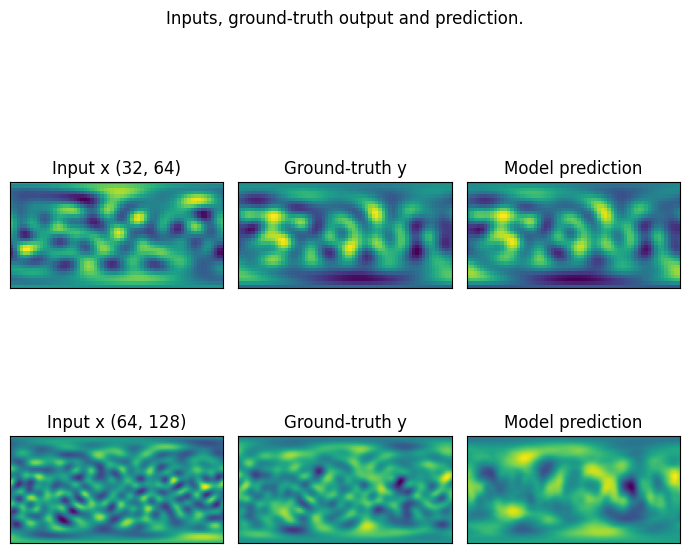

In [34]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y'][0, ...].numpy()
    # Model prediction
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()